In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded, hidden)
        output = output.contiguous().view(-1, self.hidden_size)  # (batch_size*sequence_length, hidden_size)
        output = self.fc(output)  # (batch_size*sequence_length, num_classes)
        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))

In [3]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

class TextDataset(Dataset):
    def __init__(self, text, seq_length=200, batch_size=64):
        self.text = text
        self.seq_length = seq_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        sequence = self.text[idx:idx+self.seq_length]
        label = self.text[idx+1:idx+self.seq_length+1]
    
        return char_tensor(sequence), char_tensor(label)

# assuming that `text.txt` is your file and it's located at the current directory.
with open('holmes.txt', 'r') as f:
    text = f.read()

all_characters = sorted(list(set(text)))
input_size = len(all_characters)
output_size = len(all_characters)

Epoch [1/1], Step [0/26421], Loss: 4.5930
Epoch [1/1], Step [1000/26421], Loss: 1.5337
Epoch [1/1], Step [2000/26421], Loss: 1.3803
Epoch [1/1], Step [3000/26421], Loss: 1.3013
Epoch [1/1], Step [4000/26421], Loss: 1.2484
Epoch [1/1], Step [5000/26421], Loss: 1.1985
Epoch [1/1], Step [6000/26421], Loss: 1.1915
Epoch [1/1], Step [7000/26421], Loss: 1.1994
Epoch [1/1], Step [8000/26421], Loss: 1.1900
Epoch [1/1], Step [9000/26421], Loss: 1.1611
Epoch [1/1], Step [10000/26421], Loss: 1.1412
Epoch [1/1], Step [11000/26421], Loss: 1.1618
Epoch [1/1], Step [12000/26421], Loss: 1.1537
Epoch [1/1], Step [13000/26421], Loss: 1.1260
Epoch [1/1], Step [14000/26421], Loss: 1.1521
Epoch [1/1], Step [15000/26421], Loss: 1.1295
Epoch [1/1], Step [16000/26421], Loss: 1.1308
Epoch [1/1], Step [17000/26421], Loss: 1.1126
Epoch [1/1], Step [18000/26421], Loss: 1.1117
Epoch [1/1], Step [19000/26421], Loss: 1.1036
Epoch [1/1], Step [20000/26421], Loss: 1.0984
Epoch [1/1], Step [21000/26421], Loss: 1.0941
E

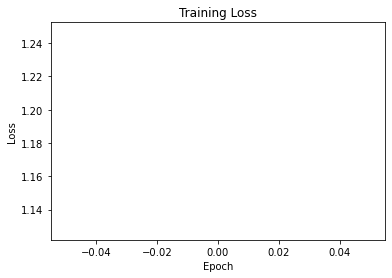

In [4]:
# Define hyperparameters
batch_size = 128
hidden_size = 128
n_layers = 2
learning_rate = 0.001
n_epochs = 1
print_every = 1000
plot_every = 100

# Create the dataset and data loader
dataset = TextDataset(text)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharRNN(input_size, hidden_size, output_size, n_layers).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Track the training loss over epochs
all_losses = []

# Set the start hidden state
hidden = model.init_hidden(128)

# Training loop
for epoch in range(1, n_epochs + 1):
    total_loss = 0.0
    #hidden = model.init_hidden(batch_size)
    for i, (input_batch, target_batch) in enumerate(itertools.islice(dataloader, len(dataloader)-1)):
            
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        optimizer.zero_grad()

        hidden = (hidden[0].detach(), hidden[1].detach())  # Detach the hidden state

        output, hidden = model(input_batch, hidden)

        loss = criterion(output.view(-1, output_size), target_batch.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % print_every == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch, n_epochs, i, len(dataloader), loss.item()))

    all_losses.append(total_loss / len(dataloader))

    if epoch % plot_every == 0:
        plt.plot(all_losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

# Plot the final training loss
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [9]:
# Set the model to evaluation mode
model.eval()

# Set the sequence length
sequence_length = 5000

# Initialize the hidden state
hidden = model.init_hidden(1)
hidden = tuple(h.to(device) for h in hidden)  # Move the hidden state to the same device as the model

# Choose a starting character or seed
start_char = 'A'

# Convert the starting character to a tensor
input_tensor = char_tensor(start_char).unsqueeze(0).to(device)  # Move the input tensor to the same device as the model

# Create an empty list to store the generated sequence
generated_sequence = []

# Loop through each step of sequence generation
for _ in range(sequence_length):
    # Pass the input tensor and hidden state to the model
    output, hidden = model(input_tensor, hidden)

    # Move the output tensor to the CPU
    output = output.cpu()

    # Sample the next character from the output distribution
    next_char_tensor = torch.multinomial(torch.exp(output.view(-1)), 1)
    next_char = all_characters[next_char_tensor.item()]

    # Append the sampled character to the generated sequence
    generated_sequence.append(next_char)

    # Set the input character for the next step as the sampled character
    input_tensor = char_tensor(next_char).unsqueeze(0).to(device)  # Move the input tensor to the same device as the model

# Join the generated sequence into a string
generated_sequence = ''.join(generated_sequence)

# Print the generated sequence
print(generated_sequence)

REOL UMA8

     The words were yond in the year for when we came friendless all thaw, the
     groom on the room cheerflest. As bare smiled, was pen," cried the
     wose coining it to take an aliabora chapting me despondently very seriously. Has a small pauses to the
     forming more. He wanted, and career it was more to had a black
     obdardly contrasted it. I remark as it
     flickered to our methods, and we had the little business, and then, in
     an horrible talent--a visit would be a time--"

     "I was. I took that to. Sharp
     had come to the lawing tribling it still and would not all closed
     a gate, taps Itapleton, he was abstuneols. From the sceptal in the edge to you
     were treng him after you, sir; it is me.  As I used to hold him from the
     groom, which may places in fire back. Adventured to kinster that lib so came-bush of an
     observation. It was loulered to whom a seeing down a witness than I doing swelles, and
     the case, sure the denied which 